In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
from scipy.stats import chi2_contingency, kstest, chi2
from scipy import stats
from statsmodels.regression.linear_model import OLSResults

Cases - участники, у которых есть заболевание
\
Controls - участники, у которых нет заболевания

In [4]:
data = pd.read_csv('Coffee_sigar.csv', sep=' ', index_col=False)

In [5]:
data = pd.DataFrame(data, columns=['coffee','cigs','cases','total'])

In [6]:
data_gr = pd.read_csv('groupdata_Coffee_sigar.csv')

In [14]:
data_gr

,cases,coffee,cigs,count
0,0,0.0,0,123
1,1,0.0,0,66
2,0,0.0,12,52
3,1,0.0,12,30
4,0,0.0,30,12
5,1,0.0,30,15
6,0,0.0,48,13
7,1,0.0,48,36
8,0,1.5,0,179
9,1,1.5,0,141


Тест Колмогорова-Смирнова на нормальность данных

H_0: Данные распределены по нормальному закону. \
H_1: Данные распределены по закону, отличному от нормального. <- 

In [7]:
kstest(data.loc[:,'cases'], cdf=stats.norm.cdf).pvalue

0.0

In [9]:
type(data)

pandas.core.frame.DataFrame

### 1) Представить графически данные

процент случаев ИМ от всех случаев(чашек кофе в день) для каждой группы(по количеству сиграет в день)

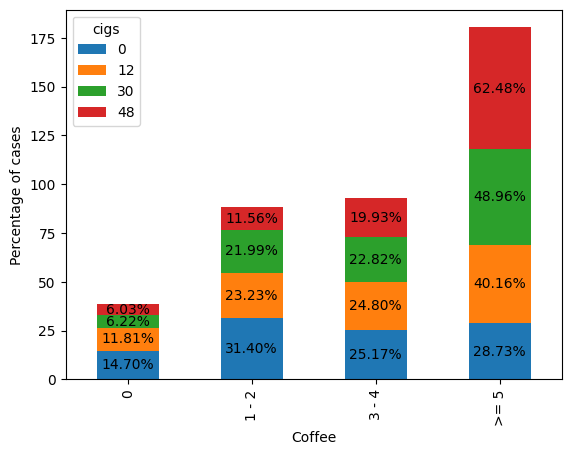

In [11]:
# Compute percentage values for each value in each group of 'cigs'
data['percent'] = data.groupby('cigs')['cases'].transform(lambda x: x / x.sum() * 100)

# Create stacked bar plot with percentage labels
fig, ax = plt.subplots()
data.pivot(index='coffee', columns='cigs', values='percent').plot(kind='bar', stacked=True, ax=ax)
ax.set_xticklabels(['0', '1 - 2', '3 - 4', '>= 5'])
ax.set_xlabel('Coffee')
ax.set_ylabel('Percentage of cases')
# ax.legend(title='Cigarettes', bbox_to_anchor=(1.01, 1), loc='upper left')
containers = ax.containers
for container in containers:
    ax.bar_label(container, label_type='center', labels=[f'{val:.2f}%' for val in container.datavalues], padding=0)

plt.show()


### 2) Проверить зависимость наблюдаемой переменной с интенсивностью курения методами классической статистики (Хи-квадрат)

Тест Хи-квадрат на независимость

H_0: между интенсивностью курения и случаями ИМ нет зависимости. \
H_1: существует зависимость между интенсивностью курения и случаями ИМ.

In [15]:
def chi2_test(table):
    chi2, p, dof, expected = chi2_contingency(table)
    return chi2, p, dof, expected

In [17]:
chi2, pv, dof, expected = chi2_test(data_gr.iloc[:, [0, 2, 3]])

In [19]:
print(chi2, pv, dof)

922.8324488077512 1.3731955168981982e-153 62


For significance level alpha = 0.01, the variables are dependent. p-value < alpha

### 3) Провести анализ зависимости наблюдаемой переменной с интенсивностью курения данных с использованием GLM (Пуассоновская модель).

Model 1: `count ~ cigs + cases + cigs*cases` \
Model 2: `count ~ cigs + cases` 

H_0: `cigs*cases = 0`
\
H_1: `cigs*cases != 0`

In [32]:
glm_model = sm.GLM.from_formula('count ~ cigs + cases + cigs*cases', data=data_gr, family=sm.families.Poisson()).fit()
glm_model_r = sm.GLM.from_formula('count ~ cigs + cases', data=data_gr, family=sm.families.Poisson()).fit()

In [33]:
glmlrt = OLSResults.compare_lr_test(glm_model, glm_model_r)
print(glmlrt)

(266.59380839741743, 6.27033920770575e-60, 1)


P-value = 2.64e^{-9}
\
Возьмем значение уровня значимости %alpha=0.01, тогда получается, что P-value < %alpha. Исходя из этого можно сделать вывод о том, что необходимо отклонить основную гипотезу и принять альтернативную

### 4) Проверить зависимость наблюдаемой переменной от двух факторов – интенсивности курения и интенсивности употребления кофе (Пуассоновская модель). Является ли значимым взаимодействие факторов. Выбрать оптимальную модель с использованием AIC и BIC

In [34]:
modelgr = sm.GLM.from_formula('count ~ cases + coffee + cigs + cases*coffee + cases*cigs + coffee*cigs + cases*coffee*cigs', data=data_gr, family=sm.families.Poisson()).fit()
modelcmp = sm.GLM.from_formula('count ~ cases + coffee + cigs + cases*coffee + cases*cigs + coffee*cigs', data=data_gr, family=sm.families.Poisson()).fit()

In [35]:
# lr test
hypelrt = OLSResults.compare_lr_test(modelgr, modelcmp)
print(hypelrt)

(3.0212602547031793, 0.08217958125914712, 1)


---------------------------------------

#### AIC и BIC - критерии

In [26]:
print(f'model 1: {modelgr.aic}, {modelgr.bic_llf}')
print(f'model 2: {modelcmp.aic}, {modelcmp.bic_llf}')

model 1: 511.0513433654005, 522.7772305877983
model 2: 512.0726036201037, 522.3327549397018
